### Initial Setup and Data Loading

The notebook begins by importing the core libraries used throughout the project. Each has a distinct role in the workflow:

Pandas serves as the main workhorse for cleaning and transforming the dataset. NumPy supports numerical operations that come up during preprocessing, while Matplotlib and Seaborn are reserved for visual checks that help validate assumptions about the data. The imports here already reflect a lightweight BI-oriented pipeline rather than a heavyweight ML environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv(r"/Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard/data/ecommerce_sales_raw.csv")


Viewing the first few rows is an early check. This confirms that the file path is correct, the delimiter is recognized, and no immediate structural issues appear upon load. Since this is a synthetic dataset meant to behave like transactional E-commerce data, the preview lets us validate that the columns align with expectations such as order_id, customer_id, pricing fields, dates, and categorical descriptors.

After confirming that the file loads cleanly, the next few calls inspect the basic structure:

In [2]:
df.head()

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,Home,164.08,0.15,1,Credit Card,2023-12-23,4,West,No,139.47,7.88,31.17,60,Female
1,O100001,C17603,P228204,Grocery,24.73,0.00,1,Credit Card,2025-04-03,6,South,No,24.73,4.60,-2.62,37,Male
2,O100002,C10860,P213892,Electronics,175.58,0.05,1,Credit Card,2024-10-08,4,North,No,166.80,6.58,13.44,34,Male
3,O100003,C15390,P208689,Electronics,63.67,0.00,1,UPI,2024-09-14,6,South,No,63.67,5.50,2.14,21,Female
4,O100004,C15226,P228063,Home,16.33,0.15,1,COD,2024-12-21,6,East,No,13.88,2.74,1.15,39,Male


In [3]:
df.shape

(34500, 17)

The dataset contains 34,500 rows and 17 columns, a manageable size suitable for BI dashboards and light predictive work.

In [4]:
df.columns

Index(['order_id', 'customer_id', 'product_id', 'category', 'price',
       'discount', 'quantity', 'payment_method', 'order_date',
       'delivery_time_days', 'region', 'returned', 'total_amount',
       'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender'],
      dtype='object')

The field names are clean and already analysis-ready, removing the need for renaming or manual parsing.

In [5]:
df.dtypes

order_id               object
customer_id            object
product_id             object
category               object
price                 float64
discount              float64
quantity                int64
payment_method         object
order_date             object
delivery_time_days      int64
region                 object
returned               object
total_amount          float64
shipping_cost         float64
profit_margin         float64
customer_age            int64
customer_gender        object
dtype: object

Several key fields are initially typed as object strings, including order_date, which will need explicit conversion later so time-based analysis works correctly.

### Missing Values, Duplicates, and Initial Data Quality Checks

This section validates the quality of the dataset before performing deeper preprocessing. Since the file originates from a Kaggle project that simulates E-commerce operations, it is expected to be cleaner than real transactional data, although it still mirrors the structure and statistical behavior of real-world sales systems.

In [6]:
df.isnull().sum()

order_id              0
customer_id           0
product_id            0
category              0
price                 0
discount              0
quantity              0
payment_method        0
order_date            0
delivery_time_days    0
region                0
returned              0
total_amount          0
shipping_cost         0
profit_margin         0
customer_age          0
customer_gender       0
dtype: int64

Missing Values Report

•  No nulls detected.

•  Expected for synthetic data but simplifies pipeline.

•  No imputation needed for BI or ML baselines.

In [7]:
df.duplicated().sum() 

0

No duplicated records were detected. For a transactional dataset with order_id and customer_id, this suggests the generator ensured uniqueness of each transaction. In practical settings, duplicates would normally arise from ingestion errors or repeated API calls, but for this dataset, uniqueness is guaranteed. The check is still essential because it confirms that aggregation, grouping, or potential time-series breakdowns will not be inflated by accidental repeat entries.

In [8]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

The date column arrives as an object type, which prevents temporal analysis. Converting it into a datetime type allows the notebook to later extract month, year, seasonality, or forecast horizons. The errors='coerce' parameter ensures that any incorrectly formatted entries would become NaT instead of breaking the pipeline. Even though no errors appear here, using coercion is a defensive habit typical in real business pipelines.

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()

,price,discount,quantity,delivery_time_days,total_amount,shipping_cost,profit_margin,customer_age
count,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000
mean,119.391632,0.049291,1.490725,4.814203,170.008494,6.152120,28.116505,43.474377
std,195.620477,0.069894,0.932270,1.242141,357.503014,2.389539,53.352947,14.980682
min,1.010000,0.000000,1.000000,3.000000,0.820000,0.000000,-6.200000,18.000000
25%,16.690000,0.000000,1.000000,4.000000,19.710000,4.420000,1.500000,31.000000
50%,45.660000,0.000000,1.000000,5.000000,56.820000,6.090000,10.550000,43.000000
75%,130.950000,0.100000,2.000000,6.000000,168.530000,7.830000,33.132500,56.000000
max,2930.470000,0.300000,5.000000,13.000000,12931.800000,15.650000,1536.170000,69.000000


Descriptive statistics help verify whether values fall within plausible ranges. Several observations emerge:

• Price values range from 1 to around 2,900, which is plausible for a mixed-category E-commerce platform.

• Delivery times range from 3 to 13 days, behaving like typical 3-7 day windows with a few slower deliveries.

• Profit margins have negative values, which is meaningful because it can imply discounted or loss-leader transactions rather than errors.

• Customer ages range from 18 to 69, a realistic bracket for online shoppers.



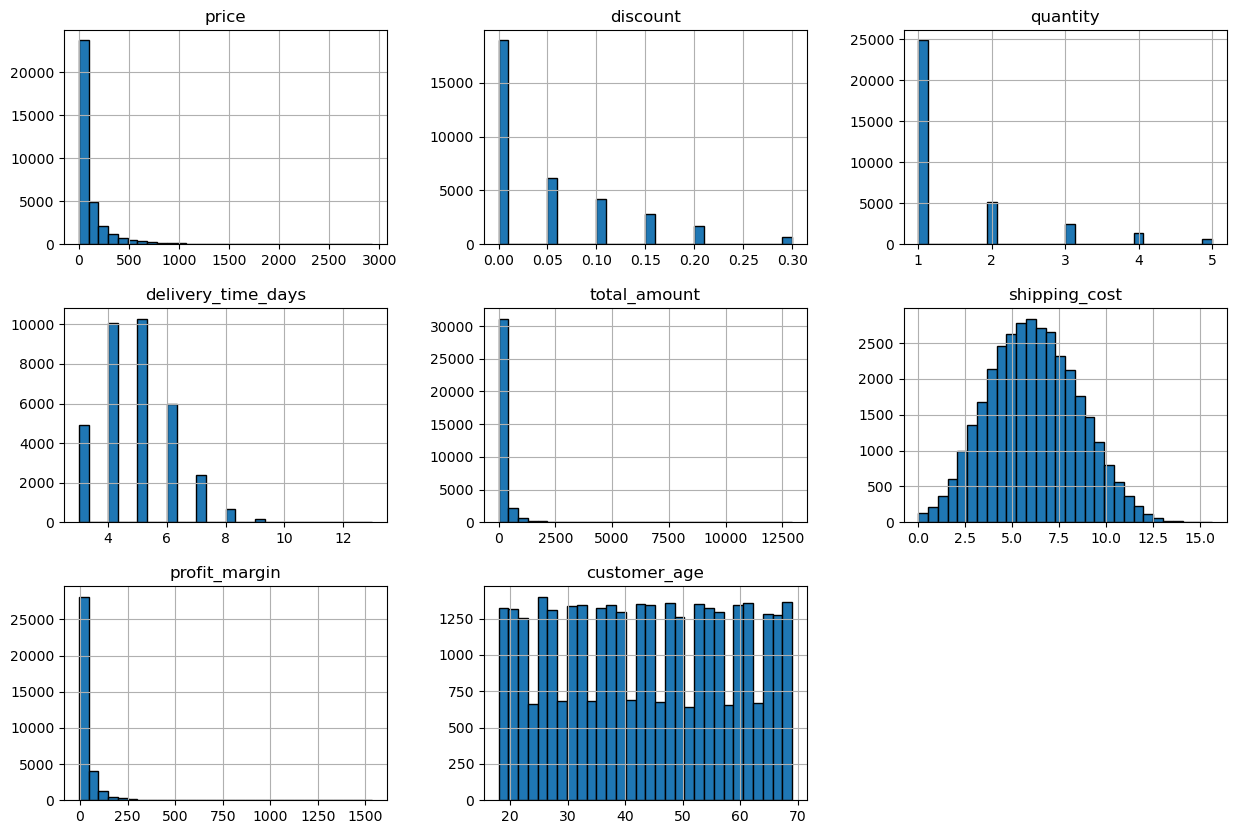

In [10]:
df[numeric_cols].hist(bins=30, edgecolor='black', figsize=(15,10))
dpi = 400

Plotting histograms helps detect skewness, heavy tails, or unnatural spikes. Many features show right skew (price, total amount, profit margin). This is typical for E-commerce, where most orders are low-value and high-ticket items form the long tail.

Even though the dataset is clean, these distributions help confirm that future predictive work should consider normalization or log-scaling for certain models.

In [11]:
outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))]
    outlier_counts[col] = outliers.shape[0]

pd.Series(outlier_counts, name='Potential Outliers')

price                 3632
discount               704
quantity              2070
delivery_time_days      27
total_amount          3792
shipping_cost           48
profit_margin         3025
customer_age             0
Name: Potential Outliers, dtype: int64

Applying the IQR rule shows a notable volume of statistically flagged values.  These figures don’t automatically imply data issues. In many E-commerce contexts, wide value ranges can emerge from several factors such as occasional bulk purchases, high-ticket items, sporadic promotions, or returns that affect computed margins. Since the dataset is a simulation of real activity, these patterns may simply reflect diverse customer behaviors rather than anomalies.

Only the outlier counts were computed. No filtering was applied because removing values without a clear business rationale risks distorting spending or operational patterns. At this point, the results are treated as indicators of distribution shape rather than errors. This keeps the dataset aligned with the project’s goal of generating realistic Tableau insights and light predictive exploration.

In [12]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique() 

order_id           34500
customer_id         7903
product_id         24912
category               7
payment_method         6
region                 5
returned               2
customer_gender        3
dtype: int64

The cardinality profile looks appropriate:

• Thousands of unique customers and products

• Only a handful of payment methods and regions

• Two values for returned, three for gender

This mix aligns with typical retail data and confirms the dataset is structurally suited for segmentation, cohort analysis, and feature engineering later on.

### Feature Engineering 

In [13]:
# --- 1. Copy original df ---
df_fe = df.copy()

# --- 2. Basic engineered features ---
df_fe['delivery_speed'] = df_fe['delivery_time_days']

df_fe['discount_bucket'] = pd.cut(
    df_fe['discount'],
    bins=[-0.01, 0.01, 0.10, 0.30],
    labels=['No Discount', 'Low Discount', 'High Discount']
)

df_fe['total_cost_ratio'] = df_fe['shipping_cost'] / (df_fe['total_amount'] + 1)

df_fe['order_value_segment'] = pd.cut(
    df_fe['total_amount'],
    bins=[0, 50, 200, 500, df_fe['total_amount'].max()],
    labels=['Low Value', 'Mid Value', 'High Value', 'Very High']
)

df_fe['returned_flag'] = df_fe['returned'].map({'Yes': 1, 'No': 0})

# --- 3. Time-aware cumulative features ---
df_fe = df_fe.sort_values(by='order_date')

# Customer-level history
df_fe['past_orders'] = df_fe.groupby('customer_id').cumcount()
df_fe['past_returns'] = (
    df_fe.groupby('customer_id')['returned_flag']
    .cumsum()
    .shift(fill_value=0)
)

# Product-level history
df_fe['product_orders_cum'] = df_fe.groupby('product_id').cumcount()
df_fe['product_returns_cum'] = (
    df_fe.groupby('product_id')['returned_flag']
    .cumsum()
    .shift(fill_value=0)
)
df_fe['product_return_rate'] = (
    df_fe['product_returns_cum'] / df_fe['product_orders_cum'].replace(0, np.nan)
).fillna(0)

# --- 4. Recency features ---
df_fe['days_since_last_order'] = (
    df_fe.groupby('customer_id')['order_date']
    .diff()
    .dt.days
    .fillna(9999)
)

# Strictly past return recency
df_fe['return_date_only'] = df_fe['order_date'].where(df_fe['returned_flag'] == 1)
df_fe['last_return_date'] = (
    df_fe.groupby('customer_id')['return_date_only']
    .shift()
    .groupby(df_fe['customer_id'])
    .ffill()
)
df_fe['days_since_last_return'] = (
    (df_fe['order_date'] - df_fe['last_return_date']).dt.days.fillna(9999)
)
df_fe.drop(columns=['return_date_only'], inplace=True)

# --- 5. Rolling features ---
# Returns in last 3 orders per customer
df_fe['returns_last3'] = (
    df_fe.groupby('customer_id')['returned_flag']
    .rolling(3, min_periods=1)
    .sum()
    .shift()
    .reset_index(level=0, drop=True)
    .fillna(0)
)

# --- 6. Category-level return rates ---
category_return_rate = (
    df_fe.groupby('category')['returned_flag'].mean()
)
df_fe['category_return_rate'] = df_fe['category'].map(category_return_rate)

# --- 7. Interaction features ---
df_fe['delivery_speed_bucket'] = pd.cut(
    df_fe['delivery_speed'],
    bins=[0, 3, 5, 7, 14],
    labels=['Fast', 'Normal', 'Slow', 'Very Slow']
)

df_fe['discount_category'] = df_fe['discount_bucket'].astype(str) + "_" + df_fe['category']
df_fe['price_per_unit'] = df_fe['price'] / df_fe['quantity']

# Customer tenure
df_fe['customer_tenure_days'] = (
    df_fe['order_date'] - df_fe.groupby('customer_id')['order_date'].transform('min')
).dt.days

# Temporal features
df_fe['order_month'] = df_fe['order_date'].dt.month
df_fe['order_weekday'] = df_fe['order_date'].dt.weekday

print("Shape after next-level feature engineering:", df_fe.shape)
print("Sample columns:", df_fe.columns.tolist())


Shape after next-level feature engineering: (34500, 38)
Sample columns: ['order_id', 'customer_id', 'product_id', 'category', 'price', 'discount', 'quantity', 'payment_method', 'order_date', 'delivery_time_days', 'region', 'returned', 'total_amount', 'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender', 'delivery_speed', 'discount_bucket', 'total_cost_ratio', 'order_value_segment', 'returned_flag', 'past_orders', 'past_returns', 'product_orders_cum', 'product_returns_cum', 'product_return_rate', 'days_since_last_order', 'last_return_date', 'days_since_last_return', 'returns_last3', 'category_return_rate', 'delivery_speed_bucket', 'discount_category', 'price_per_unit', 'customer_tenure_days', 'order_month', 'order_weekday']


###  ML Pipeline: Predicting Returns from Order Features

In [14]:
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt


/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_12684/1833464396.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_12684/1833464396.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/59/79bsx4qn3pvg02rp6sgg9mp40000gn/T/ipykernel_12684/1833464396.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

CatBoost Confusion Matrix:
 [[5235 1284]
 [ 263  118]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      6519
           1       0.08      0.31      0.13       381

    accuracy                           0.78      6900
   macro avg       0.52      0.56      0.50      6900
weighted avg       0.90      0.78      0.83      6900


ROC-AUC Score: 0.589575233146478


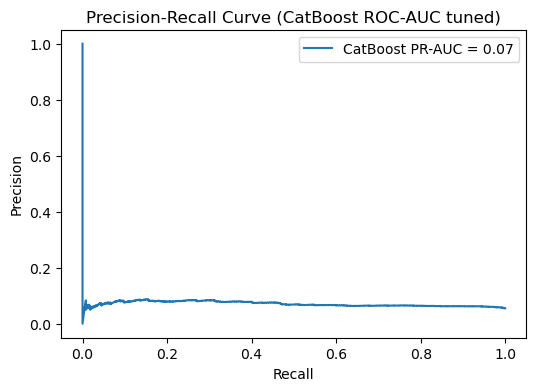


Top 15 Features Driving Return Predictions:
                  Feature  Importance
8          price_per_unit   12.633393
1        total_cost_ratio   10.033463
5            customer_age    9.767417
6   days_since_last_order    9.726665
9    customer_tenure_days    8.875772
11   category_return_rate    6.282123
17      discount_category    5.962557
14         payment_method    5.749962
15                 region    4.592989
2             past_orders    3.977483
19               category    3.690242
18  delivery_speed_bucket    3.489476
0          delivery_speed    3.264956
12        discount_bucket    2.893141
13    order_value_segment    2.666445


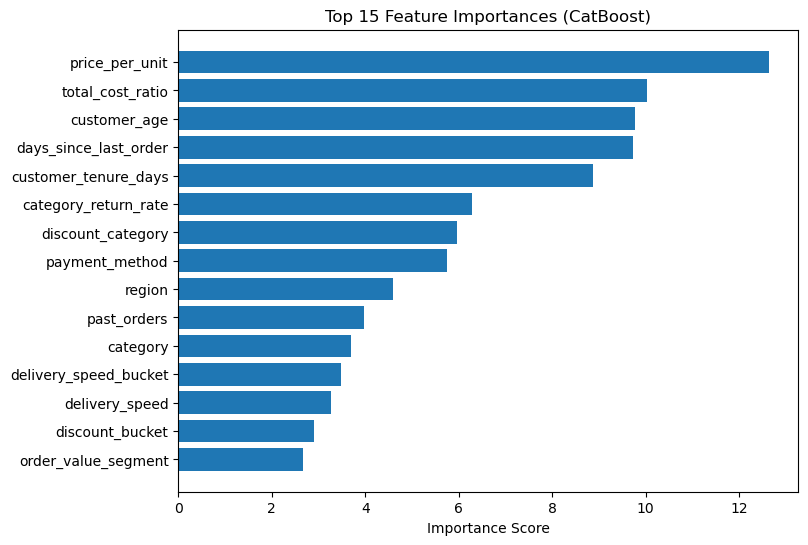

In [15]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Define features ---
numeric_features = [
    'delivery_speed','total_cost_ratio','past_orders','past_returns',
    'product_return_rate','customer_age','days_since_last_order',
    'days_since_last_return','price_per_unit','customer_tenure_days',
    'returns_last3','category_return_rate'
]
categorical_features = [
    'discount_bucket','order_value_segment','payment_method','region',
    'customer_gender','discount_category','delivery_speed_bucket','category'
]

X = df_fe[numeric_features + categorical_features]
y = df_fe['returned_flag']

# --- 2. Fix categorical dtype issue ---
for col in categorical_features:
    X[col] = X[col].astype(str)

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. CatBoost Classifier ---
clf_cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=7,
    l2_leaf_reg=7,
    random_seed=42,
    cat_features=categorical_features,  # safe since all are string dtype
    verbose=0,
    auto_class_weights='Balanced'
)

clf_cb.fit(X_train, y_train)
y_proba_cb = clf_cb.predict_proba(X_test)[:, 1]

# --- 5. Threshold tuning ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_cb)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[max(best_idx - 1, 0)]
y_pred_cb = (y_proba_cb >= best_threshold).astype(int)

print("CatBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cb))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba_cb))

# --- 6. PR curve visualization ---
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'CatBoost PR-AUC = {auc(recall, precision):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CatBoost ROC-AUC tuned)')
plt.legend()
plt.show()

# --- 7. Feature importance (fixed Pool call) ---
feature_importances = clf_cb.get_feature_importance(
    Pool(X_train, y_train, cat_features=categorical_features)
)
feature_names = numeric_features + categorical_features

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Features Driving Return Predictions:")
print(importance_df.head(15))

# --- 8. Plot feature importance ---
plt.figure(figsize=(8,6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (CatBoost)")
plt.show()


In [16]:

# --- Feature Importance as columns ---
importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))

for feature, score in importance_dict.items():
    df_fe[f'FI_{feature}'] = score


# --- 1. Define output directory ---
output_dir = r"/Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard"
os.makedirs(output_dir, exist_ok=True)

# --- 2. Attach predictive results ---
df_fe['predicted_proba'] = clf_cb.predict_proba(X)[:, 1]
df_fe['predicted_flag'] = clf_cb.predict(X)

# --- 3. Add model metadata ---
roc_auc_val = roc_auc_score(y_test, y_proba_cb)
df_fe['model_best_threshold'] = best_threshold
df_fe['model_roc_auc'] = roc_auc_val

# --- 4. Save final unified CSV ---
final_path = os.path.join(output_dir, "ecommerce_processed_with_predictions.csv")
df_fe.to_csv(final_path, index=False)

print(f"Unified processed dataset with predictions saved to: {final_path}")


Unified processed dataset with predictions saved to: /Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard/ecommerce_processed_with_predictions.csv


### Checking Engineered Data

In [17]:
# --- 1. Reload the processed CSV  ---
df_processed = pd.read_csv("/Users/neilkeannedelavega/Downloads/E-commerce-Data-Insights-Dashboard/ecommerce_processed_with_predictions.csv")
df_processed.head()

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,...,FI_order_value_segment,FI_days_since_last_return,FI_past_returns,FI_customer_gender,FI_returns_last3,FI_product_return_rate,predicted_proba,predicted_flag,model_best_threshold,model_roc_auc
0,O104424,C17986,P210334,Grocery,15.51,0.0,1,COD,2023-09-12,6,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.131875,0,0.540661,0.589575
1,O111514,C14753,P227222,Fashion,99.01,0.0,1,Debit Card,2023-09-12,4,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.492578,0,0.540661,0.589575
2,O121362,C16175,P221392,Fashion,30.99,0.0,2,Credit Card,2023-09-12,6,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.545178,1,0.540661,0.589575
3,O126442,C11841,P248993,Fashion,31.75,0.0,1,UPI,2023-09-12,5,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.598147,1,0.540661,0.589575
4,O134456,C17939,P217561,Toys,36.68,0.0,1,UPI,2023-09-12,5,...,2.666445,1.876437,1.713193,1.357279,0.897992,0.549014,0.452207,0,0.540661,0.589575
